In [1]:
#Remove punctuation and convert to lower case
import string
import nltk
import pandas as pd
comments_clean = pd.read_csv("comments.csv")
comments_clean['comments']=comments_clean['comments'].astype(str)
comments_clean = comments_clean.dropna()
comments_clean = comments_clean.drop(columns = 'Unnamed: 0')
comments_clean = comments_clean.reset_index().drop(columns='index')
comments_clean['comments'] = comments_clean['comments'].apply(lambda x :x.translate(str.maketrans('', '', string.punctuation)))
comments_clean['comments'] = comments_clean['comments'].apply(lambda x :x.lower())

In [2]:
#Import models to brand conversion file 
models = pd.read_csv("models.csv", header = None, names = ['brand','model'], encoding='windows-1252')

In [3]:
#Replace models by brands
def model_to_brand(s):
    for i in models.index.values:
        s = s.replace(models["model"][i].lower(),models["brand"][i].lower())
    return s
comments_clean['comments_model_replace'] = comments_clean['comments'].apply(model_to_brand)

In [4]:
#Tokenize and remove stop words
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
  
stop_words = set(stopwords.words('english')) 
comments_clean['comments_model_replace'] = comments_clean['comments_model_replace'].apply(word_tokenize).apply(set).apply(list)

def remove_stopwords(s):
    return [w for w in s if not w in stop_words] 
    
comments_clean['comments_model_replace'] =  comments_clean['comments_model_replace'].apply(remove_stopwords)


In [5]:
#Creating a combined list of all words
all_words = []
for i in range(len(comments_clean)):
    all_words+=comments_clean['comments_model_replace'][i]
from nltk import FreqDist
word_freq = nltk.FreqDist(all_words)

In [6]:
#Creating a list of all brand names
model_names = models['brand'].unique()

In [7]:
#Filtering counts for brands
brand_counts = []
for key,item in word_freq.most_common(1000):
    if key in model_names:
        temp = (key,item)
        brand_counts.append(temp)
        

In [8]:
#Top 10 brands
brand_counts[:10]

[('bmw', 1401),
 ('acura', 529),
 ('audi', 439),
 ('infiniti', 415),
 ('honda', 403),
 ('toyata', 209),
 ('nissan', 191),
 ('volvo', 174),
 ('ford', 143),
 ('mercedes', 143)]

#### Task A: Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. Show the brands on a multi-dimensional scaling (MDS) map.

In [9]:
top10_brand = [x[0] for x in brand_counts[:10]]
top10_brand

['bmw',
 'acura',
 'audi',
 'infiniti',
 'honda',
 'toyata',
 'nissan',
 'volvo',
 'ford',
 'mercedes']

In [10]:
# drop duplicates
post = comments_clean["comments_model_replace"].map(lambda x:list(set(x)))

In [11]:
word_cnt = []
for i in range(len(post)):
    word_cnt += post[i]
word_frq = nltk.FreqDist(word_cnt)

In [36]:
# Constructing a Lift table
brand_lift = pd.DataFrame(columns=["brand1","brand2","lift"])
for i in top10_brand:
    for j in top10_brand:
        if i != j:
            brand_lift = brand_lift.append({"brand1":i, "brand2":j, "lift":0}, ignore_index=True)

In [13]:
def word_count2(comp1, comp2, df):
    """Calculating number of posts mentioning both A and B"""
    n = 0
    for i in range(len(df)):
        if (comp1 in df[i]) & (comp2 in df[i]):
            n += 1
    return n
# total number of posts
n = len(post)

In [14]:
# calculate lift
for i in range(len(brand_lift)):
    cnt_both = word_count2(brand_lift['brand1'][i],brand_lift['brand2'][i],post)
    cnt_brand1 = word_frq[brand_lift['brand1'][i]]
    cnt_brand2 = word_frq[brand_lift['brand2'][i]]
    brand_lift['lift'].iloc[i] = cnt_both*n/(cnt_brand1 * cnt_brand2)

In [15]:
lift_mat = brand_lift.pivot(index='brand1',columns='brand2', values='lift')
lift_mat

brand2,acura,audi,bmw,ford,honda,infiniti,mercedes,nissan,toyata,volvo
brand1,,,,,,,,,,
acura,NaN,2.36781,1.37701,1.47845,3.08208,2.99296,2.27927,2.12156,1.85454,2.43009
audi,2.36781,NaN,1.65173,1.78154,1.36968,2.2509,3.19193,1.44498,1.77764,4.33142
bmw,1.37701,1.65173,NaN,1.41887,1.05646,1.69115,2.00037,1.07971,1.46416,1.29989
ford,1.47845,1.78154,1.41887,NaN,2.18328,1.41343,4.10191,2.21799,2.18289,3.74568
honda,3.08208,1.36968,1.05646,2.18328,NaN,1.56035,2.02155,3.32974,2.98764,2.06012
infiniti,2.99296,2.2509,1.69115,1.41343,1.56035,NaN,2.35572,2.35161,1.82671,1.80695
mercedes,2.27927,3.19193,2.00037,4.10191,2.02155,2.35572,NaN,1.87676,2.96249,5.43124
nissan,2.12156,1.44498,1.07971,2.21799,3.32974,2.35161,1.87676,NaN,2.21799,2.24349
toyata,1.85454,1.77764,1.46416,2.18289,2.98764,1.82671,2.96249,2.21799,NaN,2.05027


In [35]:
lift_adj = 1/lift_mat
lift_adj = lift_adj.fillna(0)

In [30]:
# Multi-dimensional scaling Map
from sklearn import manifold
import numpy as np
mds = manifold.MDS(n_components=2, dissimilarity='precomputed', random_state=1, max_iter=3000)
result = mds.fit(lift_adj)
pos = result.embedding_
X = pos[:,0]
Y = pos[:,1]

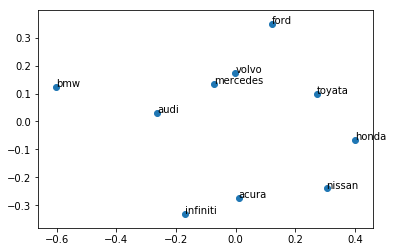

In [34]:
import matplotlib.pyplot as plt
plt.scatter(X,Y)
for i, txt in enumerate(lift_adj.index):
    plt.annotate(txt, (X[i], Y[i]))
plt.show()

#### Task B: What insights can you offer brand managers from your analysis in Task A? 

Mercedes and Volvo have the strongest association. This is an interesting relation because Mercedes is undisputably a luxury car brand, but Volvo is not. The data is from entry-level-luxury-performance-sedans forum, and it is easy to guess luxury brand such as Mercedes, Audi, and BMW will have a significant lift with each other. However, people tend to talk more about a luxury car brand with a rather normal brand.  This can be interpreted as people thinking about either buying a car with luxury brand or buying a car with reasonable price. Thus, luxury car brand managers should  not only consider other luxury brands but also qualified brands with reasonable price as competitors.

#### Task C: What are 5 most frequently mentioned attributes of cars in the discussions? Note that the same attribute may be described by different words – e.g., pick-up and acceleration may both refer to a more general attribute, “performance”. You have to make suitable replacements. Now pick the 5 most frequently mentioned brands. Which attributes are most strongly associated with which of these 5 brands? ####

In [1]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

df = pd.read_csv('comments.csv')

In [2]:
df.head(2)

,Unnamed: 0,username,date,comments
0,0,merc1,March 2002,I personally think that with a few tweaks the ...
1,1,fredvh,March 2002,I am debating a new purchase and these two are...


1. Find top 5 attributes

In [28]:
attributes = { 
    
    'performance': ['pick-up', 'accelaration', 'drive', 'engine', 'sport', 'driving', 'performance', 'power', 'speed', 
                     'fast', 'faster', 'sporty', 'horsepower', 'powerful'],
    
    'consumption': ['consumption','mile', 'mileage', 'oil', 'diesel', 'mpg', 'gas', 'fuel', 'leak'],
    
    'look': ['look', 'appearance', 'looking', 'design', 'style', 'attractive', 'designed', 'looked'],
    
    'luxury': [ 'luxury', 'premium','luxurious'],
    
    'reliability': ['issue', 'recall', 'trouble', 'concerned', 'suspension', 'reliable',
                   'service', 'warranty', 'durability', 'durance','quality', 'durable'],
    
    'price': ['value', 'cost', 'money', 'msrp', 'price', 'sale', 'offer', 'discount', 'bargain', 'grand', 'expensive',
             'cheap', 'cheaper', 'incentive', 'worth'],

    'exterior': ['headlights', 'dents', 'scratches', 'paint job', 'door'],

    'interior': ['seat', 'interior', 'leather', 'steering', 'inside', 'radio', 'noise', 'quiet', 'air conditioner',
                'heater', 'dashboard', 'cabin'],

    'experience': ['experience', 'special', 'interesting', 'impressive', 'surprised', 'amazing', 
                   'fun', 'happy', 'bad'],
    
    'safety': ['safety', 'life', 'safe', 'braking', 'seatbelt', 'airbags', 'collision' ]
}

top5_brand = ['bmw','acura','audi','infiniti','honda']

In [29]:
def get_words(line):
    """
    find individual words in comments
    """
    
    try:
        return set([word.lower() for word in word_tokenize(line)])
    except:
        pass


def get_brands(line):
    """
    find brands being mentioned in comments
    """
    try:
        return set([brand for brand in top5_brand if brand in line])
    except:
        pass



def get_attributes(line):
    """
    find attributes being mentioned in comments
    """
    try:
        return set([key for word in line for key, item in attributes.items() if word in item])
    except:
        pass


df['words'] = df['comments'].apply(get_words)
df['brand'] = df['words'].apply(get_brands)
df['attributes'] = df['words'].apply(get_attributes)

In [30]:
df.head(2)

,Unnamed: 0,username,date,comments,words,brand,attributes
0,0,merc1,March 2002,I personally think that with a few tweaks the ...,"{waiting, great, x-type, styling, england, was...","{bmw, acura, audi}","{price, reliability, performance, interior, ex..."
1,1,fredvh,March 2002,I am debating a new purchase and these two are...,"{non-type, great, generation, any, from, debat...","{honda, acura}","{reliability, price}"


In [31]:
attr_count = {}
for i in range(len(df)):
    attr = df.loc[i,'attributes']
    if attr:
        for j in attr:
            if j not in attr_count.keys():
                attr_count[j] = 1
            else:
                attr_count[j] += 1
            
rank_attr = sorted(attr_count.items(),key=lambda x:x[1],reverse=True)[:5]
pd.DataFrame.from_dict(dict(rank_attr),orient='index',columns=['count'])

,count
performance,1910
price,1265
experience,821
look,773
interior,761


The most common attributes are performance, price, experience, look and interior.

2. Find the most frequently mentioned attributes of a brand

In [32]:
top5_brand = ['bmw','acura','audi','infiniti','honda']
top5_attributes = list(dict(rank_attr).keys())

In [33]:
count = {}
for b in top5_brand:
    count[b] = {}

for i in range(len(df)):
    brand = df.loc[i,'brand']
    attributes = df.loc[i,'attributes']
    if brand:
        for b in brand:
            for a in attributes:
                if b in top5_brand and a in top5_attributes:
                    if a not in count[b].keys():
                        count[b][a] = 1
                    else:
                        count[b][a] += 1

count

{'bmw': {'price': 480,
  'performance': 625,
  'interior': 261,
  'experience': 275,
  'look': 257},
 'acura': {'price': 152,
  'performance': 220,
  'interior': 99,
  'experience': 103,
  'look': 123},
 'audi': {'price': 130,
  'performance': 190,
  'interior': 106,
  'experience': 100,
  'look': 89},
 'infiniti': {'performance': 180,
  'experience': 86,
  'price': 149,
  'interior': 81,
  'look': 82},
 'honda': {'price': 65,
  'look': 48,
  'performance': 100,
  'experience': 51,
  'interior': 33}}

In [34]:
# most frequently mentioned attributes of each brand
for i in count.keys():
    rank = sorted(count[i].items(),key=lambda x:x[1],reverse=True)
    print(i,rank[0])

bmw ('performance', 625)
acura ('performance', 220)
audi ('performance', 190)
infiniti ('performance', 180)
honda ('performance', 100)


In [35]:
# calculate LIFT score

rank_brand = [('bmw', 1401),
 ('acura', 529),
 ('audi', 439),
 ('infiniti', 415),
 ('honda', 403)]

rank_brand_dic = dict(rank_brand)
rank_attr_dic = dict(rank_attr)

n = len(df)

LIFT = {}

for brand in rank_brand_dic.keys():
    LIFT[brand] = {}
    for attr in rank_attr_dic.keys():
        if attr not in LIFT[brand].keys():
            LIFT[brand][attr] = n * count[brand][attr] / (rank_brand_dic[brand] * rank_attr_dic[attr])

In [36]:
for i in LIFT.keys():
    rank = sorted(LIFT[i].items(),key=lambda x:x[1],reverse=True)
    print(i,rank[0])

bmw ('price', 1.354199287352625)
acura ('look', 1.5039726888341645)
audi ('interior', 1.586451108869459)
infiniti ('price', 1.4191151959617125)
honda ('experience', 0.7707117447402702)


In [39]:
lift_table = pd.DataFrame(columns=list(rank_attr_dic),index=top5_brand)
for brand in LIFT.keys():
    for attr in LIFT[brand].keys():
        lift_table.loc[brand,attr] = LIFT[brand][attr]
        
lift_table

,performance,price,experience,look,interior
bmw,1.16783,1.3542,1.19542,1.18655,1.22402
acura,1.08869,1.13571,1.18579,1.50397,1.2296
audi,1.13299,1.17046,1.38727,1.31134,1.58645
infiniti,1.13543,1.41912,1.26205,1.27807,1.2824
honda,0.649578,0.637511,0.770712,0.770418,0.538015


**Task D: What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C?** 

(i) Performance is the most frequently mentioned attribute for all the top 5 brands, so it is recommended that all product managers pay close attention to the design of engines and raise their performance. If we take the lift scores into consideration, BMW and infiniti are the most strongly associated with price. Assuming a positive sentiment, we suggest product managers continue working on reducing the costs while maintaining the high performance of cars. Acura is most strongly associated with looks, so designing stylish and good-looking luxury cars for the brand is recommended. Audi is most strongly associated with interiors, while Honda is most strongly associated with experience. Product managers should focus a greater proportion of their efforts on these specific attributes.


(ii) Recommended marketing focuses:
   - BMW and Infiniti - good value for money
   - Acura - stylish luxury cars
   - Audi - luxurious interior design
   - Honda - best driving experience

**Task E: Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?**

In [2]:
import pandas as pd

In [3]:
comments_df = pd.read_csv('comments.csv')

In [4]:
aspirational = pd.read_csv('aspirational_words.csv')
asp_list = []
for x in aspirational['words']:
    asp_list.append(x)
print(asp_list)

['admiration', 'admire', 'ambition', 'ambitious', 'ardor', 'aspiration', 'aspire', 'beautiful', 'beauty', 'believe', 'best', 'bliss', 'blissful', 'breathtaking', 'catalyst', 'conquer', 'dare', 'daring', 'dedicate', 'desire', 'desiring', 'divine', 'dream', 'dream', 'eager', 'electrifying', 'empower', 'empowering', 'energized', 'envision', 'excellence', 'excellent', 'glory', 'happiness', 'happy', 'harmonious', 'harmony', 'holy', 'holy grail', 'honor', 'hope', 'ideal', 'imagination', 'imagine', 'initiative', 'innovation', 'inspire', 'inspiring', 'limitless', 'luxurious', 'nirvana', 'passion', 'passionate', 'purpose', 'relentless', 'spirit', 'spirited', 'strength', 'strong', 'trust', 'wish', 'worthy']


In [5]:
import string
import nltk
comments_df['comments']=comments_df['comments'].astype(str)
comments_df = comments_df.dropna()
comments_df['comments'] = comments_df['comments'].apply(lambda x :x.translate(str.maketrans('', '', string.punctuation)))
comments_df['comments'] = comments_df['comments'].apply(lambda x :x.lower())

In [6]:
models = pd.read_csv("models.csv", header = None, names = ['brand','model'], encoding='windows-1252')

In [7]:
def model_to_brand(s):
    for i in models.index.values:
        s = s.replace(models["model"][i].lower(),models["brand"][i].lower())
    return s
comments_df['comments_model_replace'] = comments_df['comments'].apply(model_to_brand)

In [8]:
def asp_words(x):
    for i in asp_list:
        x = x.replace(i,'aspirational')
    return x
comments_df['aspirational_words'] = comments_df['comments_model_replace'].apply(asp_words)

In [9]:
lift_df = pd.DataFrame(columns = ['brand', 'brandcount', 'asp_count', 'lift', 'percent_aspirational'])
lift_df['brand'] = models['brand'].unique()

In [10]:
overall_asp_count = 0
for comment in comments_df['aspirational_words']:
    if 'aspirational' in comment:
        overall_asp_count += 1
n = len(comments_df)

In [11]:
index = 0
for brand in lift_df['brand']:
    brandcount = 0
    asp_count = 0
    for comment in comments_df['aspirational_words']:
        if brand in comment:
            brandcount += 1
        if 'aspirational' in comment and brand in comment:
            asp_count += 1
        
    lift_df['brandcount'][index] = brandcount
    lift_df['asp_count'][index] = asp_count
    index += 1
lift_df['percent_aspirational'] = lift_df['asp_count']/lift_df['brandcount']
lift_df['lift'] = (n*lift_df['asp_count'])/(lift_df['brandcount']*overall_asp_count)
lift_df

,brand,brandcount,asp_count,lift,percent_aspirational
0,acura,584,206,1.32029,0.35274
1,audi,532,214,1.50563,0.402256
2,bmw,1461,513,1.31427,0.351129
3,buick,97,35,1.35056,0.360825
4,cadillac,146,56,1.43566,0.383562
5,chevrolet,146,60,1.53821,0.410959
6,chrysler,64,34,1.98845,0.53125
7,dodge,213,94,1.65183,0.441315
8,ford,262,101,1.4429,0.385496
9,honda,560,214,1.43035,0.382143


To assess which brands were the most 'aspirational', we decided to create a list of aspirational words (dream, beaity, desire, etc.) and replace those words with the word 'aspirational', similarly to what we did with the brands and models. From there, we did a count of how many times the brand appears in post, and then how many times the word 'aspirational' appears with that brand. From there, we calculated lifts, which can be found in the table above. The brand with the highest lift ended up being Chrysler, which we thought was interesting. We think that Chrysler could capitalize on this from a marketing perspective- Chrysler, though it is not associated with typical luxury brands like Mercedes or BMW, has a higher representation of people that aspire to own a Chrysler. Chrysler can create marketing campaigns that capitalize on this, and thus generate even further interest in the brand.